# Classification Model Training and Testing 

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [402]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sunpy.coordinates.sun import carrington_rotation_number, carrington_rotation_time
from matplotlib.colors import Normalize
import pandas as pd
import os
import shutil
import datetime 
from torch.utils.data import DataLoader, Subset
from IPython.display import clear_output

import torch
import torch.nn as nn

from storm_utils.config_paths import get_project_paths
from storm_utils.data_structure import ForecastingDataset
# from storm_regression.plotting import plot_window_data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.utils import resample

from storm_classification.ensemble_analysis import *

In [28]:
def bootstrap_calibration(y_true, y_prob, n_bins=10, n_bootstrap=200):
    """
    Compute calibration curve with bootstrap confidence intervals.
    Handles empty bins consistently.
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    boot_curves = []

    for _ in range(n_bootstrap):
        y_bs, p_bs = resample(y_true, y_prob)
        inds = np.digitize(p_bs, bins) - 1
        frac_pos = []
        for b in range(n_bins):
            mask = inds == b
            if mask.sum() > 0:
                frac_pos.append(y_bs[mask].mean())
            else:
                frac_pos.append(np.nan)  # empty bin
        boot_curves.append(frac_pos)

    boot_curves = np.array(boot_curves, dtype=float)  # (n_bootstrap, n_bins)

    # Compute statistics, ignoring NaNs for empty bins
    frac_pos_median = np.nanmedian(boot_curves, axis=0)
    frac_pos_lower = np.nanpercentile(boot_curves, 25, axis=0)
    frac_pos_upper = np.nanpercentile(boot_curves, 75, axis=0)

    return bin_centers, frac_pos_median, frac_pos_lower, frac_pos_upper


## Setting Parameters

In [347]:
#######################
# Set up metric table #
#######################

# Create run specific folder based on time of initiation
run_name = datetime.datetime.now().strftime("run_%Y-%m-%d_%H-%M-%S")

paths = get_project_paths()

outfolder = paths['classification_src'] / 'figures' / 'metric_tables'
os.makedirs(outfolder, exist_ok=True)
outpath = outfolder / f'{run_name}_metrics.csv'
with open(outpath, 'w') as f:
    f.write('Random Seed,Test Fold,Nens,Lead Time,Final Classifier,Storm Test Threshold,')
    f.write(','.join(evaluate_predictions(np.array([[1], [0]]), np.array([[1], [0]]), np.array([[1], [0]]), np.array([[1], [0]])).keys()))

######################
# Set Run Parameters #
######################

# Load in project paths
paths = get_project_paths()

# Specify files to load for dataset
huxt_run_id = 1
huxt_path = paths['huxt_data_shared'] / f'HUXt{huxt_run_id}_modified' / 'full_df.parquet'
discontinuity_path = paths['huxt_data_shared'] / f'HUXt{huxt_run_id}_modified' / 'discontinuities.npy'
fig_dir = paths['classification_src'] / 'figures' / 'calibration_plots' / run_name
fig_dir.mkdir(parents=True, exist_ok=True)

lead_times = [12] # Lead time (hours)
storm_thresholds = [5]    # Storm threshold for filtering test set
# random_seeds = [1, 42, 100, 12345, 151201]
# test_folds = range(5)

random_seeds = [1]
test_folds = [0]

for random_seed in random_seeds:
    for Lt in lead_times:
        print('Lt', Lt)
        F = 24  # Forecast Duration (hours)
        
        n_ensembles = 100
        stride_hours = 24
        storm_thresh = 4.66
        
        ###################
        # Loading Dataset #
        ###################
        print('loading dataset')
        
        forecasting_dataset = ForecastingDataset(huxt_path, discontinuity_path, Nens=n_ensembles, lead_time_hours=Lt, forecast_duration_hours=F, stride_hours=stride_hours)
        
        #############################
        # Balance Storm : Non-storm #
        #############################
        print('balancing storms by random dropout of non-storms')
        
        # Balance the dataset by random dropout of non-storm times
        forecasting_dataset.balance_storms(threshold=storm_thresh, inplace=True, random_state=random_seed)
    
        ####################
        # Train-test split #
        ####################
        for test_fold in test_folds:
            train_indices, test_indices = forecasting_dataset.rotation_aligned_train_test_split(train_ratio=0.8, test_fold=test_fold)
            # Create Training Dataset and DataLoader
            train_dataset = Subset(forecasting_dataset, train_indices)
            train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
            
            #########################
            # Extract training data #
            #########################
            print('Extracting training data')
            
            batch = next(iter(train_dataloader))
            
            v = batch['v'].numpy()             # shape: (B, 144, Nens)
            vgrad = batch['vgrad'].numpy()     # shape: (B, 144, Nens)
            vomni = batch['vomni'].numpy()     # shape: (B, 48, Nens)
            hist = batch['historic_target'].numpy()  # shape: (B, 48, 1)
            hist_rep = np.repeat(hist, forecasting_dataset.Nens, axis=2)  # shape: (B, 48, Nens)
            y_train = batch['max_target'].numpy()    # shape: (B,)
                
                
            def scale_array(arr, scaler=None):
                B, T, N = arr.shape
                flat = arr.reshape(-1, 1)  # shape: (B * T * N, 1)
                scaler = MinMaxScaler()
                flat_scaled = scaler.fit_transform(flat)
                flat_scaled = scaler.transform(flat)
                return flat_scaled.reshape(B, T, N)
            
            v_scaled = scale_array(v)
            vgrad_scaled = scale_array(vgrad)
            vomni_scaled = scale_array(vomni)
            hist_rep_scaled = scale_array(hist_rep)
            
            X_train_scaled = np.concatenate([v_scaled, vgrad_scaled, vomni_scaled, hist_rep_scaled], axis=1)
            
            X_train_scaled_transposed = np.transpose(X_train_scaled, (2, 0, 1))
            
            # Check the data is processed correctly
            X_train_scaled_transposed.shape   # shape: (Nens, B, 384)
            
            
            ##############################
            # Train Logistic Regressions #
            ##############################
            print('Training LogisticRegression models')
            
            # Train Logistic Regression models
            models = []
            
            # Binarize y as needed (e.g., y > threshold)
            y_bin_train = (y_train >= 4.66).astype(int)
            
            for ens in range(forecasting_dataset.Nens):
                X = X_train_scaled_transposed[ens]  # shape: (num_samples, features)
            
                clf = LogisticRegression(max_iter=1000)
                clf.fit(X, y_bin_train)
                models.append(clf)
            
            for storm_test_thresh in storm_thresholds:
                ########################
                # Extract testing data #
                ########################
                print('Extracting Test Data')
                # Make Test DataLoader

                print(len(test_indices))
                test_indices_filtered  = forecasting_dataset.filter_indices_by_storm_strength_and_balance(test_indices, storm_test_thresh)
                print(len(test_indices_filtered), len(set(test_indices_filtered)))
                print(f'Test size before filter: {len(test_indices)}, Test size after filter: {len(test_indices_filtered)}')
        
                test_dataset = Subset(forecasting_dataset, test_indices_filtered)
        
                test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
                
                batch = next(iter(test_dataloader))
                
                def calculate_maes(v_historic, omni):
                    ''' calculates MAE per ensemble, per window, between historic v and historic v_omni
                    v_historic shape: (B, 48, Nens)
                    omni shape:       (B, 48)
                    '''
                    omni_expanded = np.expand_dims(omni, axis=0)                # shape: (1, B, 48)
                    v_historic_transposed = np.transpose(v_historic, (2, 0, 1)) # shape: (Nens, B, 48)
                
                    mae = np.mean(np.abs(omni_expanded - v_historic_transposed), axis=2)  # shape: (Nens, B)
                
                    return mae.T  # shape: (B, Nens)
                
                v = batch['v'].numpy()             # shape: (B, 144, Nens)
                print(v.shape)
                vgrad = batch['vgrad'].numpy()     # shape: (B, 144, Nens)
                vomni = batch['vomni'].numpy()     # shape: (B, 48, Nens)
                omni = batch['omni'].numpy()       # shape: (B, 48)
                v_historic = v[:, :omni.shape[-1]] # shape: (B, 48, Nens)
                twenty_seven_day_target = batch['27_day_target'].numpy()
                maes = calculate_maes(v_historic, omni)
                
                hist = batch['historic_target'].numpy()  # shape: (B, 48, 1)
                hist_rep = np.repeat(hist, forecasting_dataset.Nens, axis=2)  # shape: (B, 48, Nens)
                
                y_test = batch['max_target'].numpy()    # shape: (B,)
                
                v_scaled = scale_array(v)
                vgrad_scaled = scale_array(vgrad)
                vomni_scaled = scale_array(vomni)
                hist_rep_scaled = scale_array(hist_rep)
                
                X_test_scaled = np.concatenate([v_scaled, vgrad_scaled, vomni_scaled, hist_rep_scaled], axis=1)
                
                X_test_scaled_transposed = np.transpose(X_test_scaled, (2, 0, 1))
                
                X_test_scaled_transposed.shape  # shape: (Nens, B, 384)
        
                print(X_test_scaled_transposed.shape)
                
                
                ##############################################
                # Individual Logistic Regression Predictions #
                ##############################################
                print('Making individual logistic regression predictions')
                
                # Binarize y as needed (e.g., y > threshold)
                y_bin_test = (y_test >= storm_thresh).astype(int)
                
                ps = []
                for ens in range(n_ensembles):
                    X = X_test_scaled_transposed[ens]
                
                    model = models[ens]
                
                    # Predict and extract probability for class 1
                    p = model.predict_proba(X)[:, 1]
                
                    ps.append(p)
                
                ps = np.array(ps).T
                
                
                ##################################
                # Weighted mean (final forecast) #
                ##################################
                print('Making final forecasts')
                
                maes.shape, ps.shape
                
                inv_sq = 1 / (maes ** 2)
                row_sums = np.sum(inv_sq, axis=1, keepdims=True)
                weights = inv_sq / row_sums
                
                # Model Forecast:
                weighted_forecasts = np.sum(ps * weights, axis=1)

                #################
                # Platt Scaling #
                #################

                # Reshape forecasts if necessary
                X_cal = weighted_forecasts.reshape(-1, 1)
                
                # Fit logistic regression for Platt scaling
                platt_model = LogisticRegression(solver='lbfgs')
                platt_model.fit(X_cal, y_bin_test)
                
                # Get calibrated probabilities
                calibrated_forecasts = platt_model.predict_proba(X_cal)[:, 1]

                ###################
                # Baseline Models #
                ###################
                
                # Persistence Forecast: 
                y_pred_persistence = hist.squeeze()[:, -1] >= storm_thresh
            
                # 27-day recurrence Forecast:
                y_pred_27_day_recurrence = np.max(twenty_seven_day_target, axis=-1) >= storm_thresh
                
        
                ##########################
                # Write to metric tables #
                ##########################
                print('Calculating Metrics')
                
                model_metrics = evaluate_predictions(weighted_forecasts, y_pred_persistence, y_pred_27_day_recurrence, y_bin_test)

                calibrated_metrics = evaluate_predictions(calibrated_forecasts, y_pred_persistence, y_pred_27_day_recurrence, y_bin_test)
                
                persistence_metrics = evaluate_predictions(y_pred_persistence, y_pred_persistence, y_pred_27_day_recurrence, y_bin_test)
            
                twentyseven_day_recurrence_metrics = evaluate_predictions(y_pred_27_day_recurrence, y_pred_persistence, y_pred_27_day_recurrence, y_bin_test)
                
                with open(outpath, 'a') as f:
                    f.write(f'\n{random_seed},{test_fold},{n_ensembles},{Lt},weighted_mean,{storm_test_thresh},')
                    f.write(','.join([str(i) for i in model_metrics.values()]))
                    # f.write(f'\n{random_seed},{test_fold},{n_ensembles},{Lt},calibrated_weighted_mean,{storm_test_thresh},')
                    # f.write(','.join([str(i) for i in calibrated_metrics.values()]))
                    f.write(f'\n{random_seed},{test_fold},{n_ensembles},{Lt},persistence,{storm_test_thresh},')
                    f.write(','.join([str(i) for i in persistence_metrics.values()]))
                    f.write(f'\n{random_seed},{test_fold},{n_ensembles},{Lt},27_day_recurrence,{storm_test_thresh},')
                    f.write(','.join([str(i) for i in twentyseven_day_recurrence_metrics.values()]))

                #####################
                # Model Calibration #
                #####################

                # --- Before Platt Scaling ---
                mean_pred, median, lower, upper = bootstrap_calibration(y_bin_test, weighted_forecasts)
                
                plt.figure(figsize=(6,6))
                plt.plot(mean_pred, median, marker='o', label="Model forecast (median)")
                plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
                plt.fill_between(mean_pred, lower, upper, alpha=0.2, label="IQR (25–75%)")
                plt.xlabel("Predicted probability", fontsize=20)
                plt.ylabel("Observed frequency", fontsize=20)
                plt.xticks(fontsize=22)
                plt.yticks(fontsize=22)
                plt.legend()
                plt.grid(True)
                savepath = fig_dir / f'bootstrapped_calibration_{storm_test_thresh}_{Lt}.png'
                plt.savefig(savepath, bbox_inches='tight')
                plt.show()
                
                # # --- After Platt Scaling ---
                # mean_pred, median, lower, upper = bootstrap_calibration(y_bin_test, calibrated_forecasts)
                
                # plt.figure(figsize=(6,6))
                # plt.plot(mean_pred, median, marker='o', label="Platt-scaled model (median)")
                # plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
                # plt.fill_between(mean_pred, lower, upper, alpha=0.2, label="IQR (25–75%)")
                # plt.xlabel("Predicted probability")
                # plt.ylabel("Observed frequency")
                # plt.title("Calibration plot after Platt scaling")
                # plt.legend()
                # plt.grid(True)
                # savepath = fig_dir / f'bootstrapped_scaled_calibration_{storm_test_thresh}_{Lt}.png'
                # plt.savefig(savepath, bbox_inches='tight')
                # plt.show()

            clear_output(wait=True)
        
print('########')
print('# Done #')
print('########')

########
# Done #
########


## Case studies

no. windows: 672 | no. forecasts: 672
1632


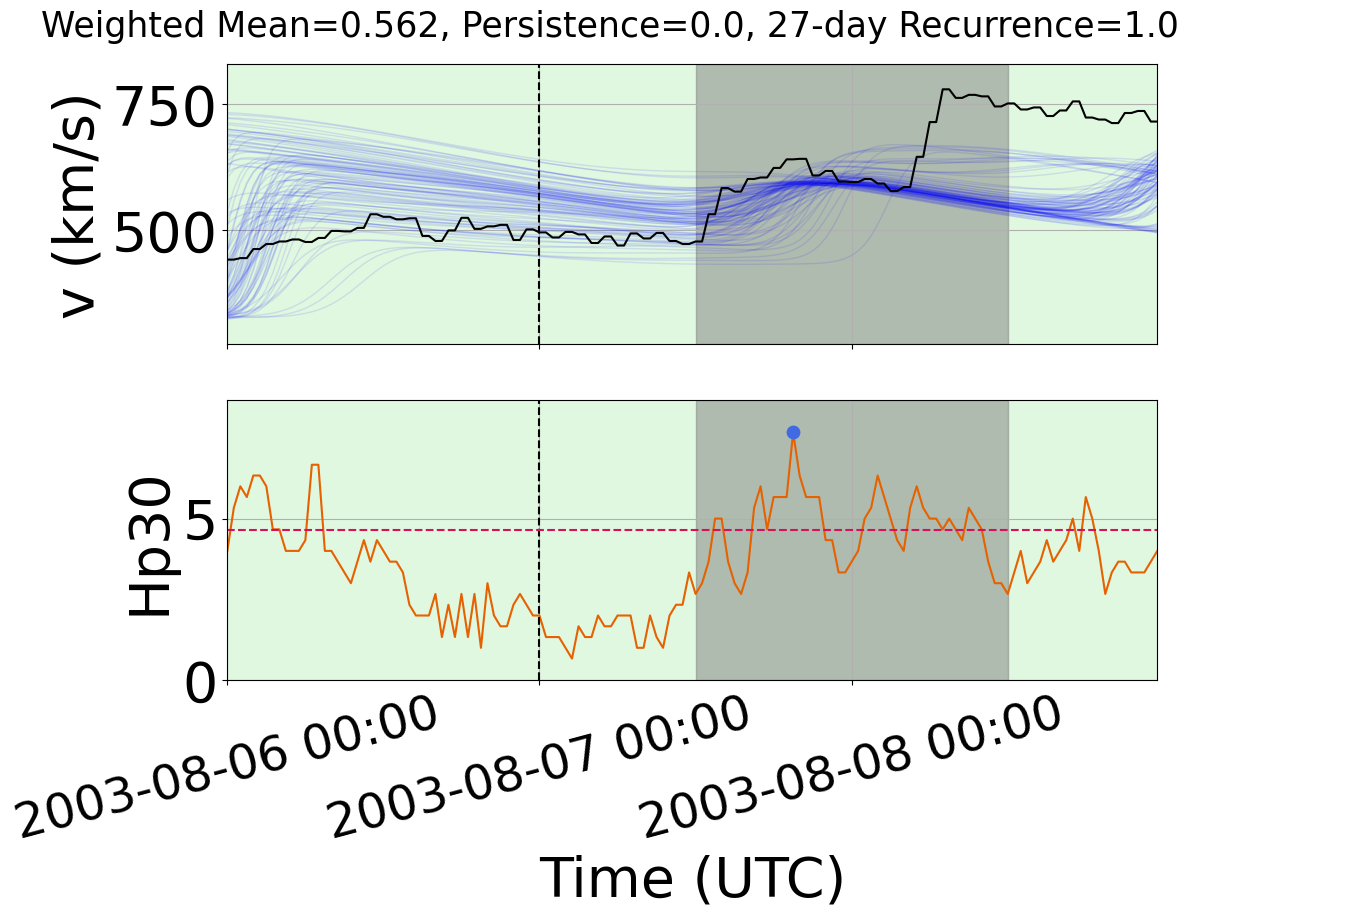

In [398]:
# True Positives (case study = 1632)

# set save path

figure_dir = paths['storm_utils_figures'] / 'data_plots'

# sort arrays by max Hp30

sorted_test_indices_filtered, order = forecasting_dataset.sort_indices_by_storm_strength(test_indices_filtered, return_order=True)

sorted_weighted_forecasts = weighted_forecasts[order]
sorted_y_pred_persistence = y_pred_persistence[order]
sorted_y_pred_27_day_recurrence = y_pred_27_day_recurrence[order]

print('no. windows:', len(test_indices_filtered), '| no. forecasts:', len(weighted_forecasts))

for i, forecast, pers, twentyseven in zip(sorted_test_indices_filtered, 
                                          sorted_weighted_forecasts, 
                                          sorted_y_pred_persistence, 
                                          sorted_y_pred_27_day_recurrence):
    # Extract data for plotting
    window = forecasting_dataset.__getitem__(i, return_time=True)
    target = window['max_target']

    if forecast > 0.5 and target > 4.66:
        print(i)
        plot_window_data(window, forecasting_dataset.min_offset, forecasting_dataset.max_offset, forecast=forecast, persistence=pers, twentyseven=twentyseven)
outpath = figure_dir / 'quadrant_TP.png'
plt.savefig(outpath, bbox_inches='tight')

4358


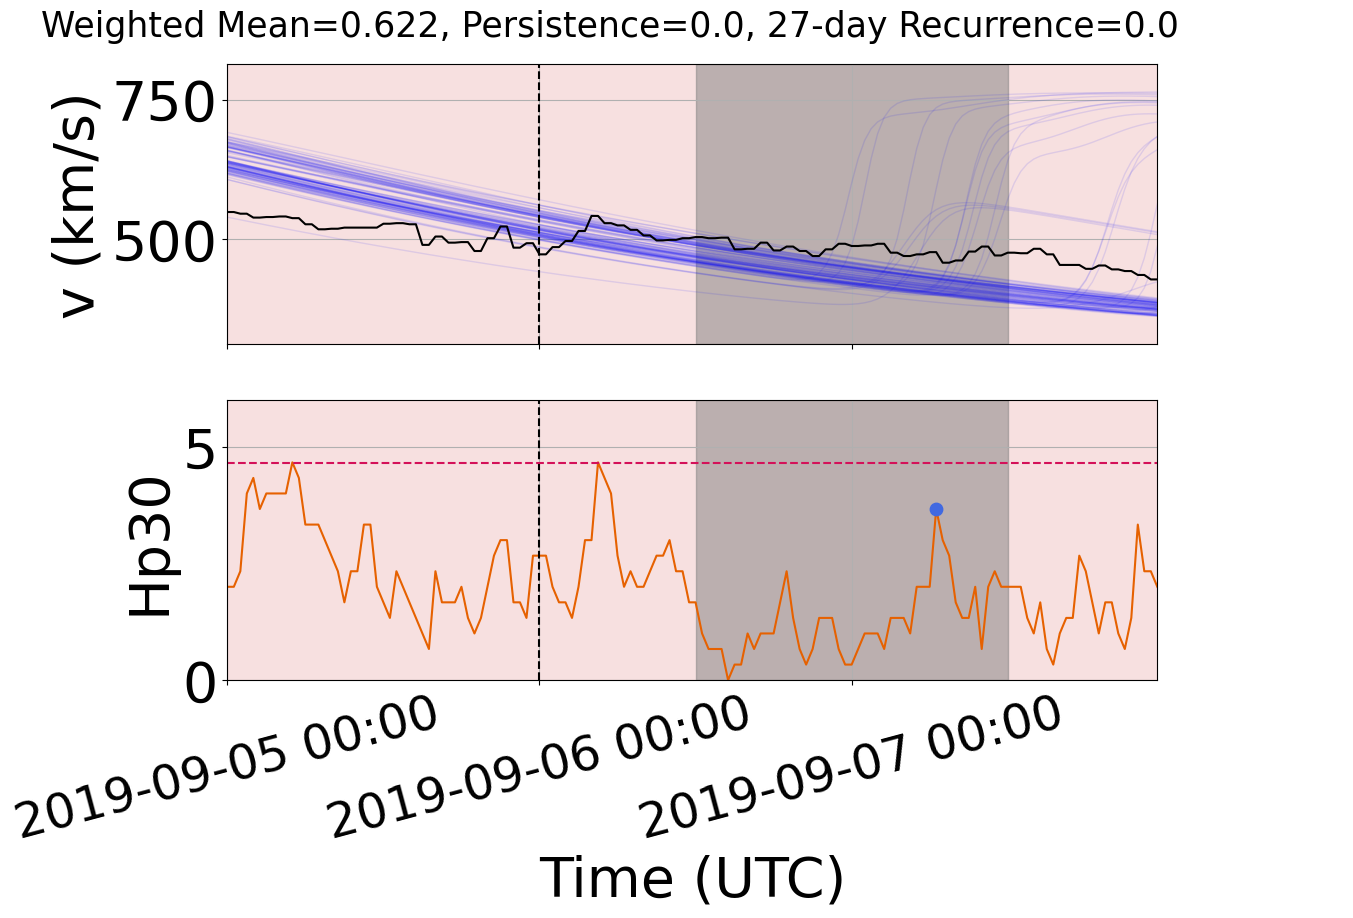

In [399]:
## False Positives (case study = 4358)

for i, forecast, pers, twentyseven in zip(sorted_test_indices_filtered, 
                                          sorted_weighted_forecasts, 
                                          sorted_y_pred_persistence, 
                                          sorted_y_pred_27_day_recurrence):
    # Extract data for plotting
    window = forecasting_dataset.__getitem__(i, return_time=True)
    target = window['max_target']

    if forecast > 0.5 and target < 4.66:
        print(i)
        plot_window_data(window, forecasting_dataset.min_offset, forecasting_dataset.max_offset, forecast=forecast, persistence=pers, twentyseven=twentyseven)

outpath = figure_dir / 'quadrant_FP.png'
plt.savefig(outpath, bbox_inches='tight')

948


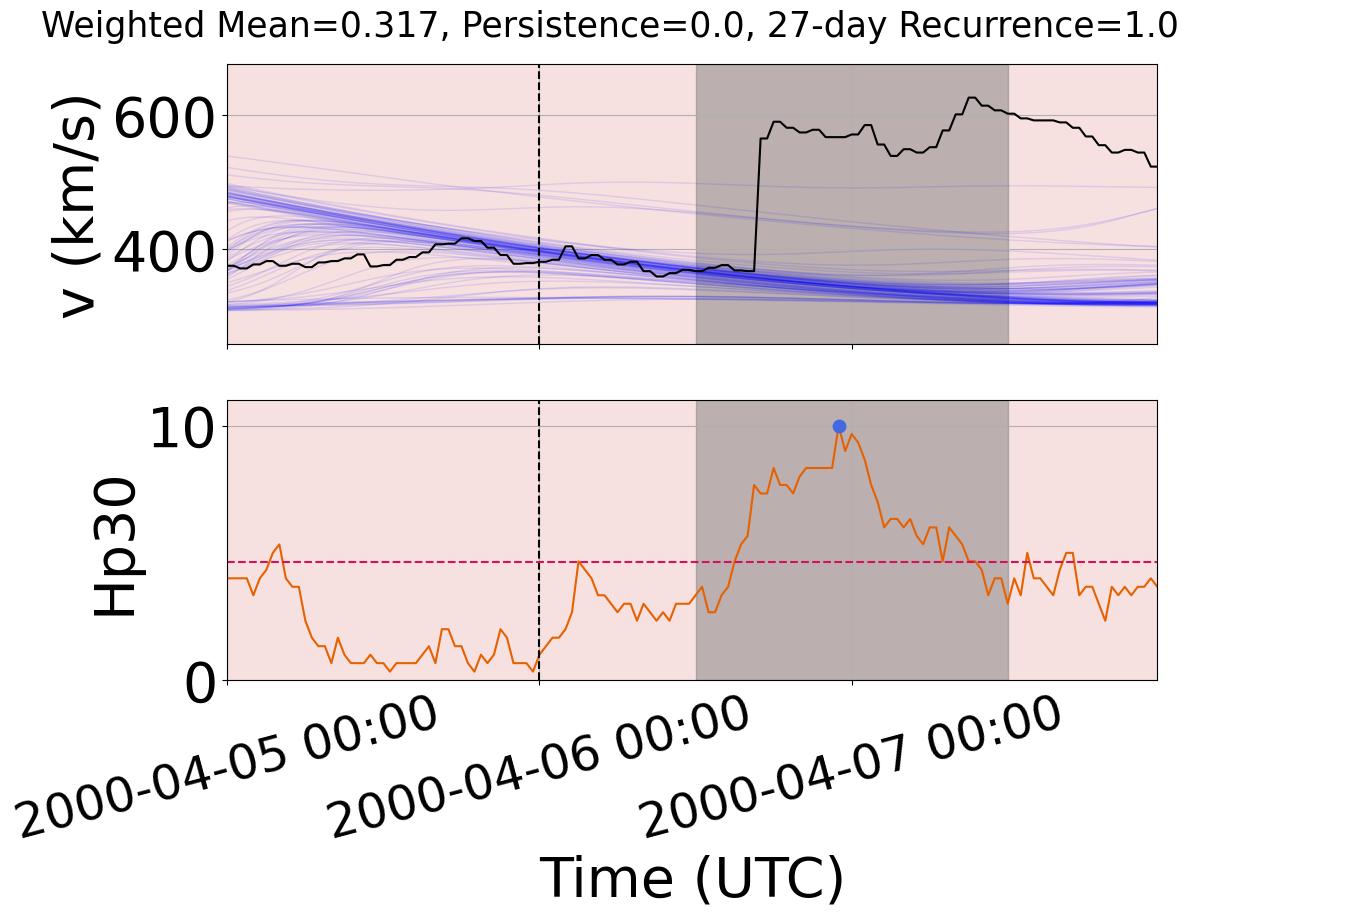

In [400]:
## False Negatives (case study = 948)

for i, forecast, pers, twentyseven in zip(sorted_test_indices_filtered, 
                                          sorted_weighted_forecasts, 
                                          sorted_y_pred_persistence, 
                                          sorted_y_pred_27_day_recurrence):
    # Extract data for plotting
    window = forecasting_dataset.__getitem__(i, return_time=True)
    target = window['max_target']

    if forecast < 0.5 and target > 4.66:
        print(i)
        plot_window_data(window, forecasting_dataset.min_offset, forecasting_dataset.max_offset, forecast=forecast, persistence=pers, twentyseven=twentyseven)

outpath = figure_dir / 'quadrant_FN.png'
plt.savefig(outpath, bbox_inches='tight')

2683


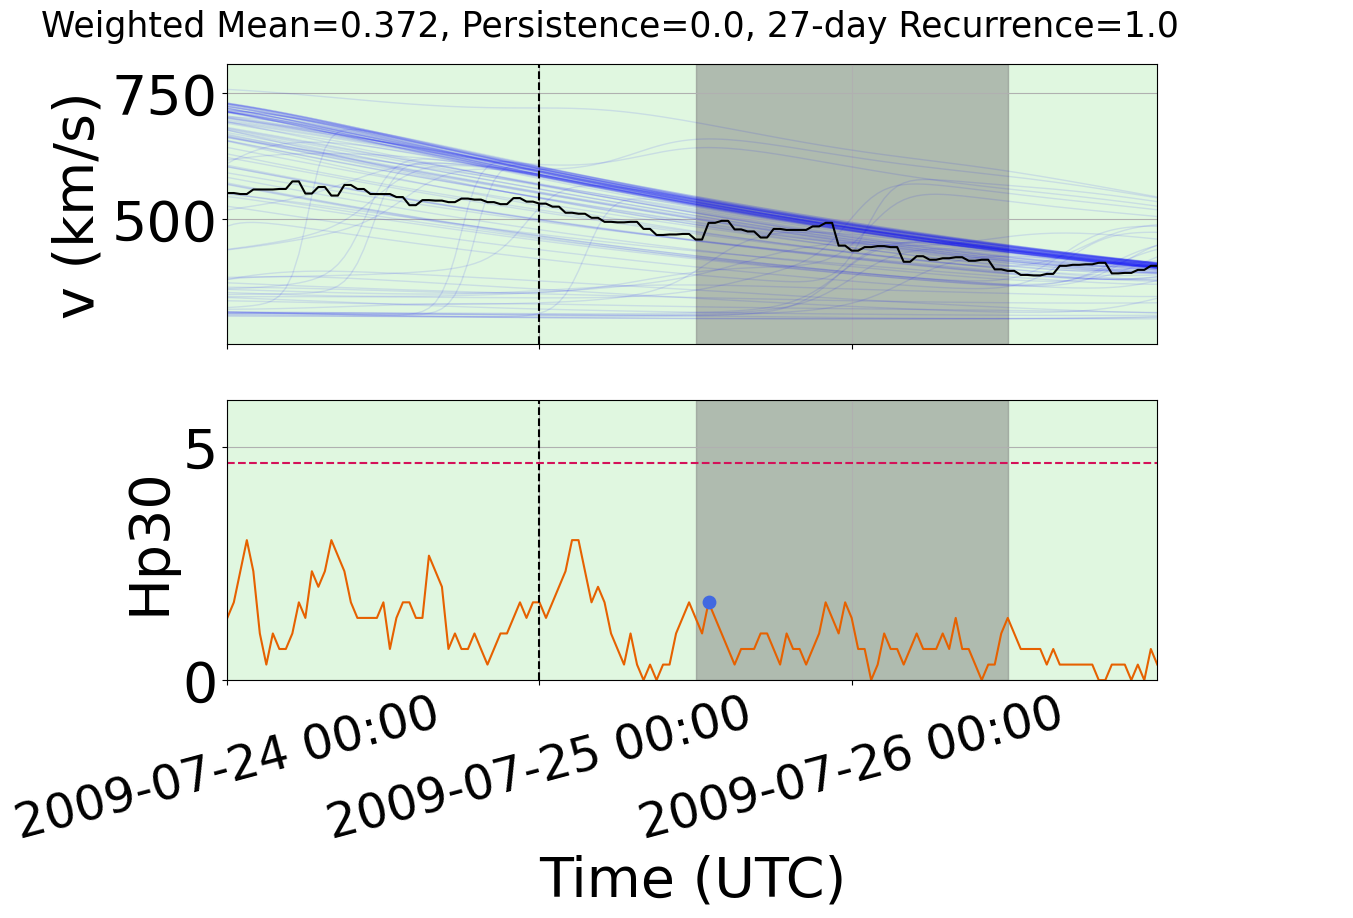

In [401]:
## True Negatives (Case study = 3563 or 2683)

for i, forecast, pers, twentyseven in zip(sorted_test_indices_filtered, 
                                          sorted_weighted_forecasts, 
                                          sorted_y_pred_persistence, 
                                          sorted_y_pred_27_day_recurrence):
    # Extract data for plotting
    window = forecasting_dataset.__getitem__(i, return_time=True)
    target = window['max_target']

    if forecast < 0.5 and target < 4.66:
        print(i)
        plot_window_data(window, forecasting_dataset.min_offset, forecasting_dataset.max_offset, forecast=forecast, persistence=pers, twentyseven=twentyseven)

outpath = figure_dir / 'quadrant_TN.png'
plt.savefig(outpath, bbox_inches='tight')
 